## Holonomic RRT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as Axes3D
from scipy.constants import g
import os
import shutil

In [2]:
class tree_node:
    def __init__(self, pose):
        self.pose = pose
        self.children = []
        self.parent = None
    
    def add_child(self, child):
        self.children.append(child)
    
    def define_parent(self, parent):
        self.parent = parent

In [49]:
class holonomic_RRT:
    def __init__(self, start_config, goal):
        self.psi = 0
        self.m = 1
        self.goal = goal
        self.tree = tree_node(start_config)
        self.reached_goal = False
        self.goal_node = None
        
    def acceleration_command(self,theta,phi,T):
        """
        Derive ax,ay,az from theta,phi,T
        """
        c_theta, s_theta = np.cos(theta), np.sin(theta)
        c_phi, s_phi = np.cos(phi), np.sin(phi)
        c_psi, s_psi = np.cos(self.psi), np.sin(self.psi)
        acc_const = T / self.m
        
        ax = (- c_phi * s_theta * c_psi - s_phi * s_psi) * acc_const
        ay = (- c_phi * s_theta * s_psi - s_phi * c_psi) * acc_const
        az = -g + (c_phi * c_theta) * acc_const
        
        return (ax, ay, az)
        
    def acceleration_control(self, a):
        """
        Convert accelerations to position
        """
        t = 1
        time_constant = t**2 / 2
        
        dx = a[0] * time_constant
        dy = a[1] * time_constant
        dz = a[2] * time_constant
        
        # return (self.tree.pose[0] + dx, self.tree.pose[1] + dy, self.tree.pose[2] + dz)
        return dx, dy, dz
    # implement holonomic RRT 
     
    def isValid(self, node1, node2):
        # TODO: check if valid node
        return True
    
    def validate(self, node1, node2):
        if self.isValid(node1, node2):
            return np.linalg.norm(np.array(node1.pose) - np.array(node2.pose))
        
        return -1
    
    def goal_reached(self, new_pose):
        return self.goal == new_pose
        # return np.all(np.isclose(np.array(self.goal), np.array(new_pose),  atol = 1))
    
    def add_node(self, new_node):
        node_queue = [self.tree]
        # new_node = tree_node(new_pose)
        
        min_dist = self.validate(self.tree, new_node)
        min_node = self.tree
        
        while (len(node_queue) > 0):
            curr_node = node_queue.pop(0)
            dist = self.validate(curr_node, new_node)
            
            if dist < min_dist:
                min_node = curr_node
                min_dist = dist
            
            node_queue.extend(curr_node.children)
        
        if min_dist == -1:
            return
        
        min_node.children.append(new_node)
        new_node.parent = min_node
        
        if (self.goal_reached(new_node.pose)):
            self.reached_goal = True
            self.goal_node = new_node
            
    def plot_line(self, ax, pose1, pose2, color, linewidth = 1):
        ax.plot([pose1[0], pose2[0]], 
                [pose1[1], pose2[1]],
                [pose1[2], pose2[2]],
                color = color,
                linewidth = linewidth)
    
    def inside_environment(self, pose, env):
        return (pose[0] >= env[0] and pose[0] <= env[3] and 
                pose[1] >= env[1] and pose[1] <= env[4] and 
                pose[2] >= env[2] and pose[2] <= env[5])
        
    def showtree(self, environment, ax, T_max = 150, path = "q2_images/tree"):
        """
        Create a new directory (say holonomic_tree) and save snapshots of the evolution of the RRT tree
        at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        if os.path.isdir(path):
            shutil.rmtree(path)
            
        os.mkdir(path)
        
        # fig = plt.figure()
        # ax = Axes3D.Axes3D(fig)
        midpoints = np.array(((environment[0] + environment[3] / 2),
                              (environment[1] + environment[4] / 2),
                              (environment[2] + environment[5] / 2)))
        
        count = 1
        while self.reached_goal == False:
            theta = np.deg2rad(np.round(360 * np.random.rand(1)[0]))
            phi = np.deg2rad(np.round(360 * np.random.rand(1)[0]))
            T = np.round(T_max * np.random.rand(1)[0])
            
            a = self.acceleration_command(theta, phi, T)
            new_pose = tuple(midpoints + self.acceleration_control(a))
            if not self.inside_environment(new_pose, environment):
                continue
            
            new_node = tree_node(new_pose)
            self.add_node(new_node)
            parent = new_node.parent
            
            if parent == None:
                continue
                
            self.plot_line(ax, new_pose, parent.pose, 'red')
                    # rstride=1, cstride=1,color=(0.1, 0.15, 0.3, 0.2),zorder = 1)
            plt.savefig(f"{path}/snap{count}.png")
            count += 1
            
            if count % 10 == 0 and self.reached_goal == False:
                goal_node = tree_node(self.goal)
                self.add_node(goal_node)
                
                if self.reached_goal:
                    self.plot_line(ax, goal_node.pose, goal_node.parent.pose, 'red')
                    plt.savefig(f"{path}/snap{count}.png")
                    break
            
        # ax.view_init(60, 35)
        # plt.show()
        
    def showpath(self, ax, path = "q2_images/path"):
        """
        Create a new directory (say holonomic_path) and save snapshots of the robot moving along the
        trajectory found by RRT at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        if not self.reached_goal:
            print("Not reached yet")
            return
        
        if os.path.isdir(path):
            shutil.rmtree(path)
            
        os.mkdir(path)
        
        final_path = []
        curr_node = self.goal_node
        
        while curr_node != None:
            final_path.append(curr_node)
            curr_node = curr_node.parent
            
        final_path.reverse()
        
        # fig = plt.figure()
        # ax = Axes3D.Axes3D(fig)
        # xs,ys,zs = self.tree.pose
        # ax.scatter(xs,ys,zs)
        # xg, yg, zg = self.goal
        # ax.scatter(xg, yg, zg)
        
        count = 1
        for i in range(len(final_path) - 1):
            self.plot_line(ax, final_path[i].pose, final_path[i+1].pose, 'blue', linewidth = 1)
            plt.savefig(f"{path}/snap{count}.png")
            count += 1
            
        # plt.show()
        
        
    def cuboid_data(self, box):
        l = box[3] - box[0]
        w = box[4] - box[1]
        h = box[5] - box[2]
        x = [[0, l, l, 0, 0],
             [0, l, l, 0, 0],
             [0, l, l, 0, 0],
             [0, l, l, 0, 0]]
        y = [[0, 0, w, w, 0],
             [0, 0, w, w, 0],
             [0, 0, 0, 0, 0],
             [w, w, w, w, w]]
        z = [[0, 0, 0, 0, 0],
             [h, h, h, h, h],
             [0, 0, h, h, 0],
             [0, 0, h, h, 0]]
        return box[0] + np.array(x), box[1] + np.array(y), box[2] + np.array(z)
        
    def test_env(self, obstacles, environment):
        # create map with obstacles
        self.tree.children = []
        self.reached_goal = False
        self.goal_node = None
        
        fig = plt.figure()
        ax = Axes3D.Axes3D(fig)
        
        xs,ys,zs = self.tree.pose
        ax.scatter(xs,ys,zs)
        xg, yg, zg = self.goal
        ax.scatter(xg, yg, zg)
        
        for box in obstacles:
            X, Y, Z = self.cuboid_data(box)
            # print(X,Y,Z)
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1,color=(0.1, 0.15, 0.3, 0.2), zorder = 1)
            
        self.showtree(environment, ax)
        self.showpath(ax)
        plt.show()

In [50]:
np.array((1,2,3)) + (2,4,5)

array([3, 6, 8])

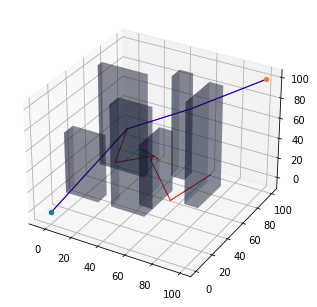

In [51]:
start = (0,1,0)
goal = (100,100,100)

# 3D boxes   lx, ly, lz, hx, hy, hz
obstacles= [[-5, 25, 0, 20, 35, 60],
            [30, 25, 0, 55, 35, 100],
            [45, 35, 0, 55, 60, 60],
            [45, 75, 0, 55, 85, 100],
            [-5, 65, 0, 30, 70, 100],
            [70, 50, 0, 80, 80, 100]]

environment = [-5, -5, -5, 105, 105, 105]
        
hn_RRT = holonomic_RRT(start,goal)
hn_RRT.test_env(obstacles, environment)

In [44]:
np.all(np.isclose(np.array([1,1,-1]), np.array([0,0,0]),  atol = 1))

True

___

In [ ]:
# import numpy as np
# from matplotlib.ticker import MaxNLocator

# x = np.array([1,1,1,1,0,0,1,1,1,0,1,1,0,0,0,0,1,1])
# x2 = np.ma.masked_where(x == 0, x)
# plt.plot(x2)

# frame1 = plt.gca()
# frame1.axes.get_yaxis().set_visible(False)
# frame1.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.show()

In [ ]:
theta = (np.round(360 * np.random.rand(1)[0]))
phi = (np.round(360 * np.random.rand(1)[0]))
T = np.round(1000 * np.random.rand(1)[0])

theta,phi, T